# Setup

In [3]:
import os
import random
import datetime
import importlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.linalg import cond
from typing import List

# Matrixlib
from matrixlib import preconditioning as prec
from matrixlib.core import MatrixData, ValueProperties, BlockProperties

#import CNN
import CNN.models
import CNN.training
import CNN.evaluation

# Check wd
current_base_path = os.getcwd()
print(f"Path to current working directory: {current_base_path}")
!whoami

2024-06-22 22:19:35.933964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 22:19:38.043133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Path to current working directory: /home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project
moonchild


In [2]:
# !pip install tensorflow-gpu==2.3.0

In [3]:
# !pip install tensorflow[and-cuda]

In [5]:
# import sys
# import os
# 
# # Add the project directory to the Python path
# sys.path.append('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# 
# # Change the working directory to the project directory
# os.chdir('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# print(os.getcwd())  # Verify the change
# tf.config.list_physical_devices('GPU') # Verify the GPU is available

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [31]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 1000
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42
VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

initialized        data vectors of size   1000 x  64 x  64 =   4096000 with a memory usage of  15.625 MiB
initialized  data start vectors of size   1000 x  64       =     64000 with a memory usage of   0.061 MiB
initialized noise start vectors of size   1000 x  64       =     64000 with a memory usage of   0.061 MiB
initialized        band vectors of size   1000 x  64 x  10 =    640000 with a memory usage of   5.127 MiB
--------------------------------------------------------------------------------
instantiation rng generators...
generating matrices...
invalid matrices: 0
determinant abs-value range: [0.020763317123055458, 4128080.25]


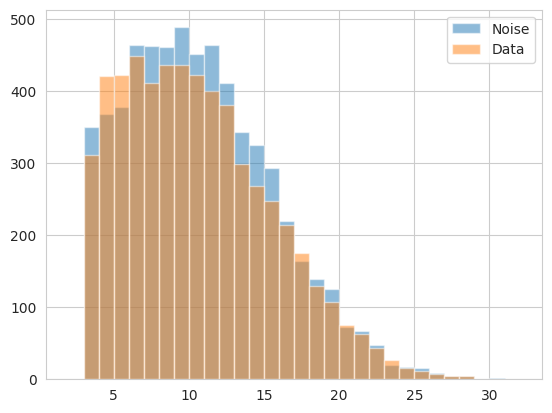

duration: 12.93 seconds


In [32]:
    # Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=True
    )

In [33]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.tdata_blk_starts
print(f"Matrix Bands Shape: {bands.shape}, Matrix Labels Shape: {labels.shape}")

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Create test matrices and labels
test_matrices = test_data.matrices[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Verify Shape
print(f"Test Matrices Shape: {test_matrices.shape}, Test Labels Shape: {test_labels.shape}")
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

# Verifiy datasets
print(train_dataset)
print(val_dataset)
print(test_dataset)

Matrix Bands Shape: (1000, 21, 64, 1), Matrix Labels Shape: (1000, 64)
Test Matrices Shape: (100, 64, 64), Test Labels Shape: (100, 64)
Train size: 800, Val size: 100, Test size: 100
<_ShuffleDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(21, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int8, name=None))>


# Training
run tensorboard --logdir logs to launch tensorboard

In [ ]:
importlib.reload(CNN.training)
importlib.reload(CNN.models)

# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)
num_epochs = 2

# Create log dir
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seeds()

# Compile Model
model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(2),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(2),
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir
)

In [ ]:
# Plot losses
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses.

    Args:
        train_losses (list of float): List of training losses per epoch.
        val_losses (list of float): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluation

In [ ]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(2),
    loss_fn=loss_fn
)

In [ ]:
importlib.reload(CNN.models)
# Restore weights from best run
new_model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
new_model.build(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
new_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# best_checkpoint_file = os.path.join(log_dir, "baseline_final.weights.h5")  
new_model.load_weights("/home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project/logs/fit/20240622-141850/model.20-1.2401.weights.h5")

# Log model weights after loading
print("Model weights after loading:")
print(new_model.get_weights())

# Evaluate the restored model
new_results = CNN.evaluation.evaluate_model(
    model=new_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

# Prediction

In [ ]:
# Extract test matrices and labels from dataset
test_bands = bands[train_size + val_size:]
print(f"labels[0] = {labels[train_size + val_size]}")
test_labels = labels[train_size + val_size:]
print(f"test_labels[0] = {test_labels[0]}")
# Make Predictions
test_predictions = trained_model.predict(test_dataset.batch(2))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Calculate Metrics
overall_accuracy = (binary_predictions == test_labels).mean()
print("Overall Accuracy:")
print(overall_accuracy)


# Create Preconditioner from predicted block starts
### 1. Form Blocks from Predictions
### 2. Invert Blocks (ensure non-singularity)
### 3. Create Block Diagonal Matrix



In [35]:
importlib.reload(prec)

A = np.array([prec.prepare_matrix(test_matrices[i], method='flip') for i in range(test_matrices.shape[0])])
A_minmax = np.array([prec.prepare_matrix(test_matrices[i], method='minmax') for i in range(test_matrices.shape[0])])
precs = prec.block_jacobi_preconditioner_from_predictions(test_matrices, test_labels)
b = np.ones((A.shape[0], A.shape[1]))

# Check Condition Numbers
print(f"Condition number original: {cond(test_matrices[0])}")
print(f"Condition number prepared flipped: {cond(A[0])}")
print(f"Condition number prepared minmax: {cond(A_minmax[0])}")
print(f"Condition number preconditioner: {cond(precs[0])}")
print(f"Condition number Product: {cond(np.matmul(A[0], precs[0]))}")
print(f"Frobenius norm of difference between preconditioner and inverse: {np.linalg.norm(precs[0] - np.linalg.inv(A[0]))}")

Matrix is singular, using pseudo-inverse for block 23 at indices 61:64
Matrix is singular, using pseudo-inverse for block 26 at indices 60:64
Matrix is singular, using pseudo-inverse for block 27 at indices 61:64
Matrix is singular, using pseudo-inverse for block 28 at indices 60:64
Matrix is singular, using pseudo-inverse for block 29 at indices 62:64
Matrix is singular, using pseudo-inverse for block 58 at indices 61:64
Matrix is singular, using pseudo-inverse for block 63 at indices 37:39
Matrix is singular, using pseudo-inverse for block 70 at indices 62:64
Matrix is singular, using pseudo-inverse for block 71 at indices 60:64
Matrix is singular, using pseudo-inverse for block 78 at indices 10:12
Matrix is singular, using pseudo-inverse for block 81 at indices 61:64
Condition number original: 267.3004150390625
Condition number prepared flipped: 6509.30029296875
Condition number prepared minmax: 106.70255279541016
Condition number preconditioner: 131.3969268798828
Condition number P

(100, 64, 64)
Condition number of matrix 0: 267.3004150390625
Condition number of matrix 1: 809.5377807617188
Condition number of matrix 2: 1895.7469482421875
Condition number of matrix 3: 1271.87841796875
Condition number of matrix 4: 147.76275634765625
Condition number of matrix 5: 528.1627807617188
Condition number of matrix 6: 679.7461547851562
Condition number of matrix 7: 456.88330078125
Condition number of matrix 8: 380.3627014160156
Condition number of matrix 9: 264.9125061035156
Condition number of flipped matrix 0: 6509.30029296875
Condition number of flipped matrix 1: 34825.4453125
Condition number of flipped matrix 2: 827.6182250976562
Condition number of flipped matrix 3: 1398.0509033203125
Condition number of flipped matrix 4: 3037.313232421875
Condition number of flipped matrix 5: 13953.8603515625
Condition number of flipped matrix 6: 2102.190673828125
Condition number of flipped matrix 7: 847.89013671875
Condition number of flipped matrix 8: 4669.349609375
Condition num

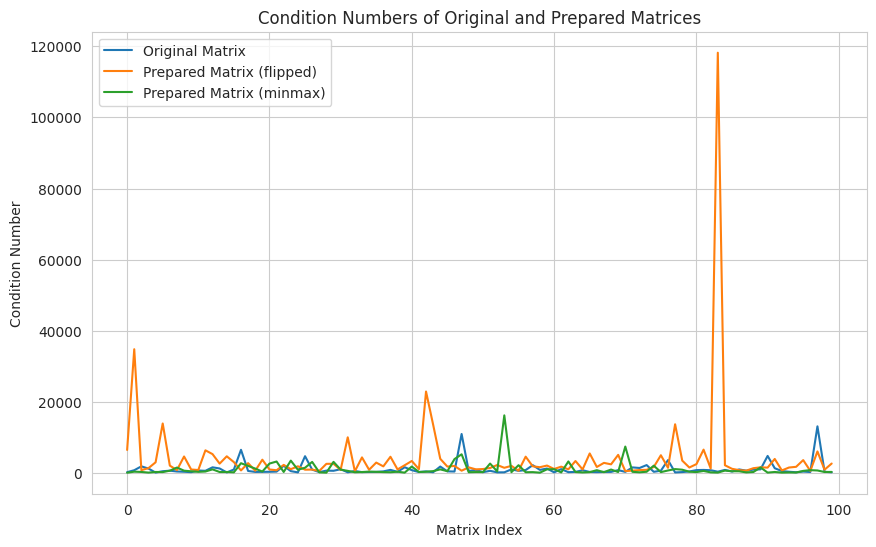

In [36]:
print(test_matrices.shape)
# print(binary_predictions.shape)

for i in range(min(10, test_matrices.shape[0])):
    print(f"Condition number of matrix {i}: {np.linalg.cond(test_matrices[i])}")

for i in range(min(10, A.shape[0])):
    print(f"Condition number of flipped matrix {i}: {np.linalg.cond(A[i])}")

for i in range(min(10, precs.shape[0])):
    print(f"Condition number of minmax matrix {i}: {np.linalg.cond(A_minmax[i])}")
    
# plot condition numbers 
plt.figure(figsize=(10, 6))
plt.plot([np.linalg.cond(test_matrices[i]) for i in range(test_matrices.shape[0])], label='Original Matrix')
plt.plot([np.linalg.cond(A[i]) for i in range(A.shape[0])], label='Prepared Matrix (flipped)')
plt.plot([np.linalg.cond(A_minmax[i]) for i in range(A_minmax.shape[0])], label='Prepared Matrix (minmax)')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.show()

# Run GMRES Solver with and without Precodnitioner

In [37]:
importlib.reload(prec)

# Solve with and without preconditioner
x_no_prec_original, info_no_prec_original, iters_no_prec_original, residuals_no_prec_original = prec.solve_with_gmres_monitored(test_matrices, b)
x_no_prec, info_no_prec, iters_no_prec, residuals_no_prec = prec.solve_with_gmres_monitored(A, b)
x_prec, info_prec, iters_prec, residuals_prec = prec.solve_with_gmres_monitored(A, b, M=precs)
x_prec_minmax, info_prec_minmax, iters_prec_minmax, residuals_prec_minmax = prec.solve_with_gmres_monitored(A_minmax, b, M=precs)

# Calculate and print the relative residuals
rel_residuals_no_prec = [np.linalg.norm(b[i] - A[i] @ x_no_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]
rel_residuals_prec = [np.linalg.norm(b[i] - A[i] @ x_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]

print("\nRelative residual:")
print(f"  Without preconditioner: min={np.min(rel_residuals_no_prec):.2e}, max={np.max(rel_residuals_no_prec):.2e}, mean={np.mean(rel_residuals_no_prec):.2e}")
print(f"  With preconditioner: min={np.min(rel_residuals_prec):.2e}, max={np.max(rel_residuals_prec):.2e}, mean={np.mean(rel_residuals_prec):.2e}")

Without preconditioner:
  Converged: 91 out of 100
  Average iterations: 3919.74
  iterations: [  595  2899   268 12800   515  7196  3890   575  1011   693  3250  1851
  6659 11067   392  2990  9890  1975   833  1074  1041  1039  8577  5475
   933 12800  4053  1752  3306  1346 12800   358  5617   953  1122  1069
  2227 12526  1910 12800   286  1507  3428  1276 12800  2777   851 12800
  2470  2925   801  1175   698  1426  6266  2730  6328  6537  7744  6364
  1419  3777   427  1073  1830  2259  1036  1003  1276  3273  1217  9120
  3991  2700   461  2297  4564   751   788  1490  4636  4784  8242  1606
 12800  1590  4190  3184 12182  3633 12800  4347  5497  1630  1095  4191
  1170 12800  2923   606]
Without preconditioner:
  Converged: 99 out of 100
  Average iterations: 867.40
  iterations: [ 1387   631   521   487   230    67   254    96   110   475   247   678
    66  1106  3142   263   223   417   149   445   254    54   411   197
   106    58   462   150    71  2196   331  5070   114 

Iteration count statistics:
Original (no preconditioner): {'min': 268, 'max': 12800, 'mean': 3919.74, 'median': 2383.5}
Prepared (no preconditioner): {'min': 54, 'max': 12800, 'mean': 867.4, 'median': 307.5}
Prepared (with preconditioner): {'min': 64, 'max': 12786, 'mean': 1057.23, 'median': 312.0}
Prepared minmax (with preconditioner): {'min': 160, 'max': 12800, 'mean': 2912.58, 'median': 794.5}


/tmp/ipykernel_5015/1904808966.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax],


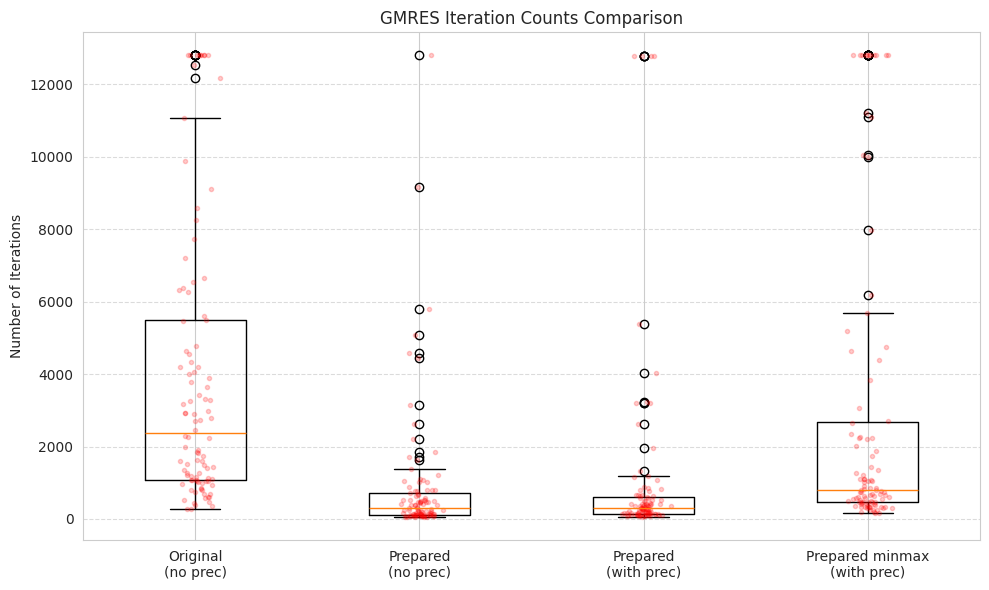

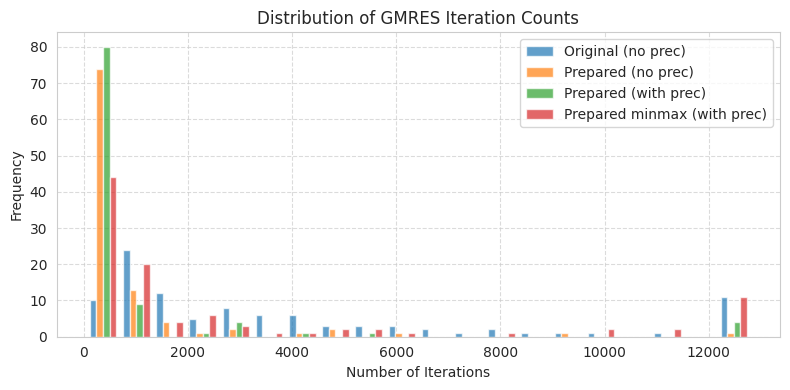

In [38]:
# Calculate statistics for iteration counts
def iter_stats(iters):
    return {
        'min': np.min(iters),
        'max': np.max(iters),
        'mean': np.mean(iters),
        'median': np.median(iters)
    }

# Print statistics
print("Iteration count statistics:")
print(f"Original (no preconditioner): {iter_stats(iters_no_prec_original)}")
print(f"Prepared (no preconditioner): {iter_stats(iters_no_prec)}")
print(f"Prepared (with preconditioner): {iter_stats(iters_prec)}")
print(f"Prepared minmax (with preconditioner): {iter_stats(iters_prec_minmax)}")

# Create box plots
plt.figure(figsize=(10, 6))
bp = plt.boxplot([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax], 
                 labels=['Original\n(no prec)', 'Prepared\n(no prec)', 'Prepared\n(with prec)', 'Prepared minmax\n(with prec)'])

plt.title('GMRES Iteration Counts Comparison')
plt.ylabel('Number of Iterations')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add some jitter to the data points
for i, data in enumerate([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax], 1):
    x = np.random.normal(i, 0.04, size=len(data))
    plt.plot(x, data, 'r.', alpha=0.2)

plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
plt.hist([iters_no_prec_original, iters_no_prec, iters_prec, iters_prec_minmax], 
         label=['Original (no prec)', 'Prepared (no prec)', 'Prepared flipped (with prec)', 'Prepared minmax (with prec)'],
         bins=20, alpha=0.7)
plt.xlabel('Number of Iterations')
plt.ylabel('Frequency')
plt.title('Distribution of GMRES Iteration Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

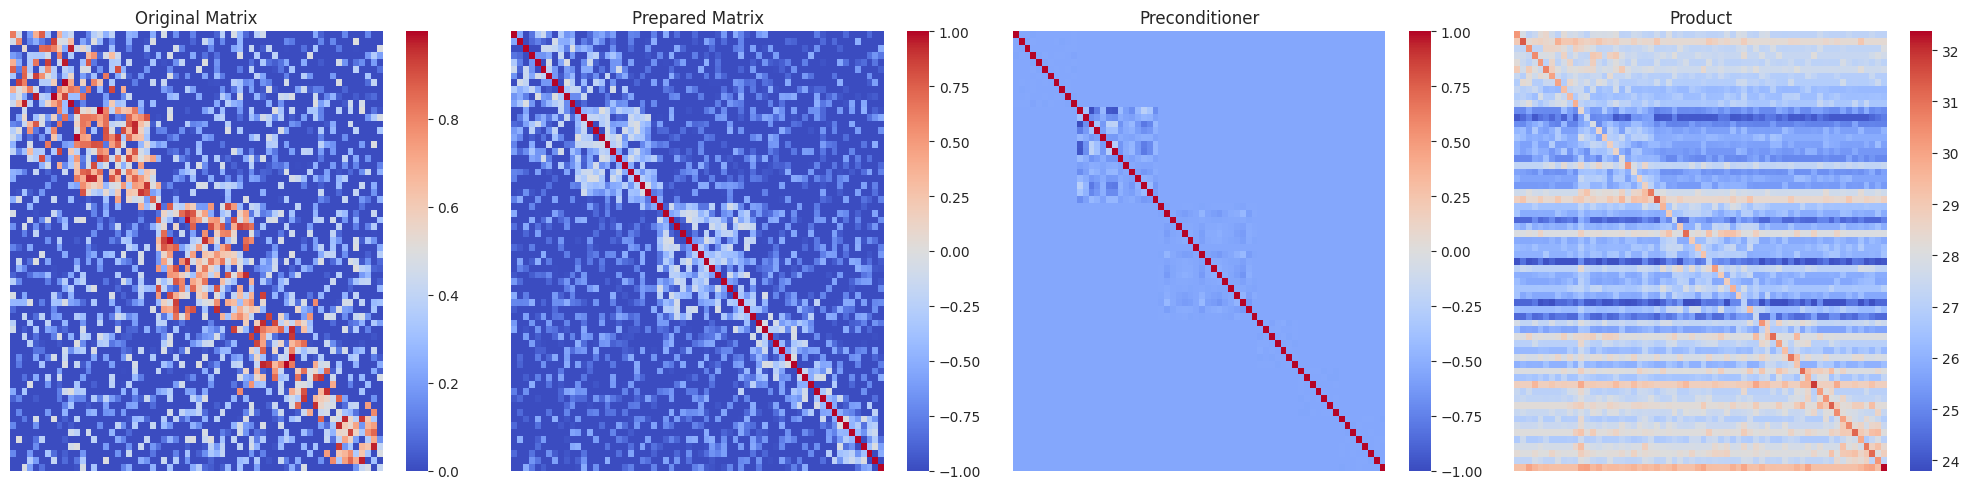

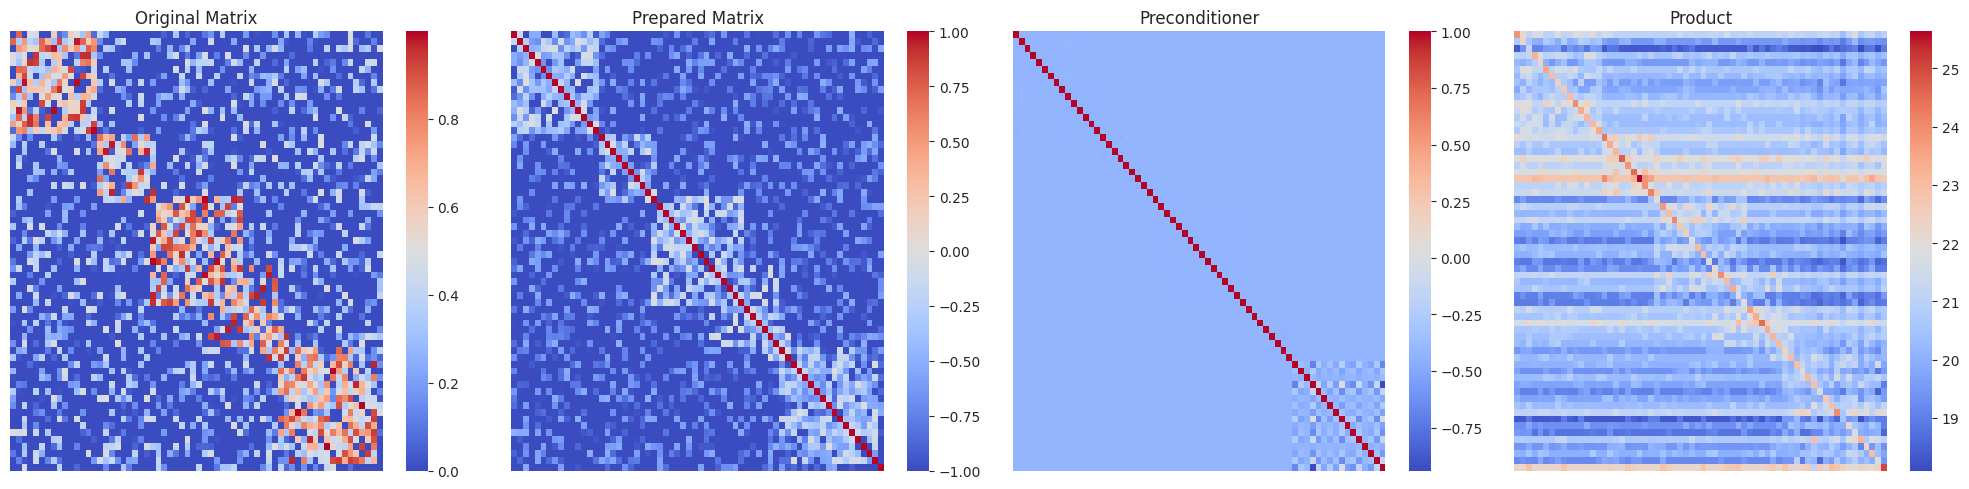

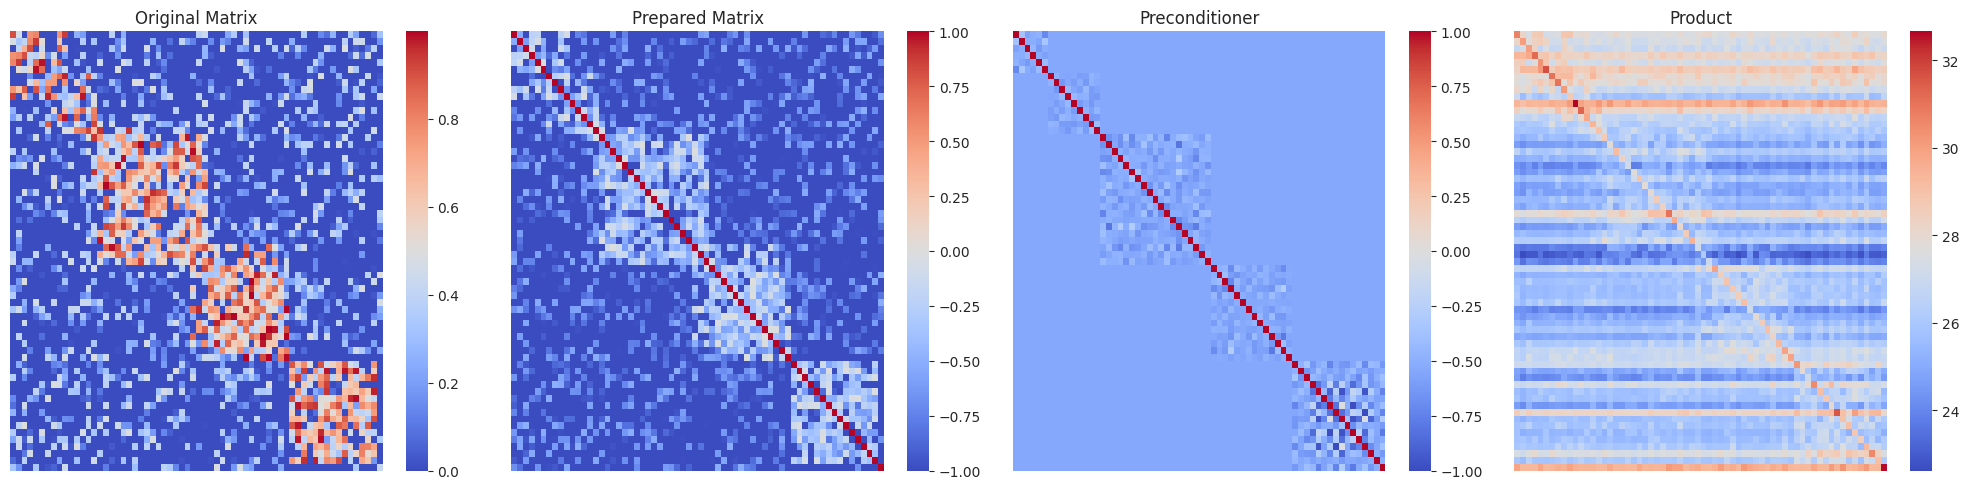

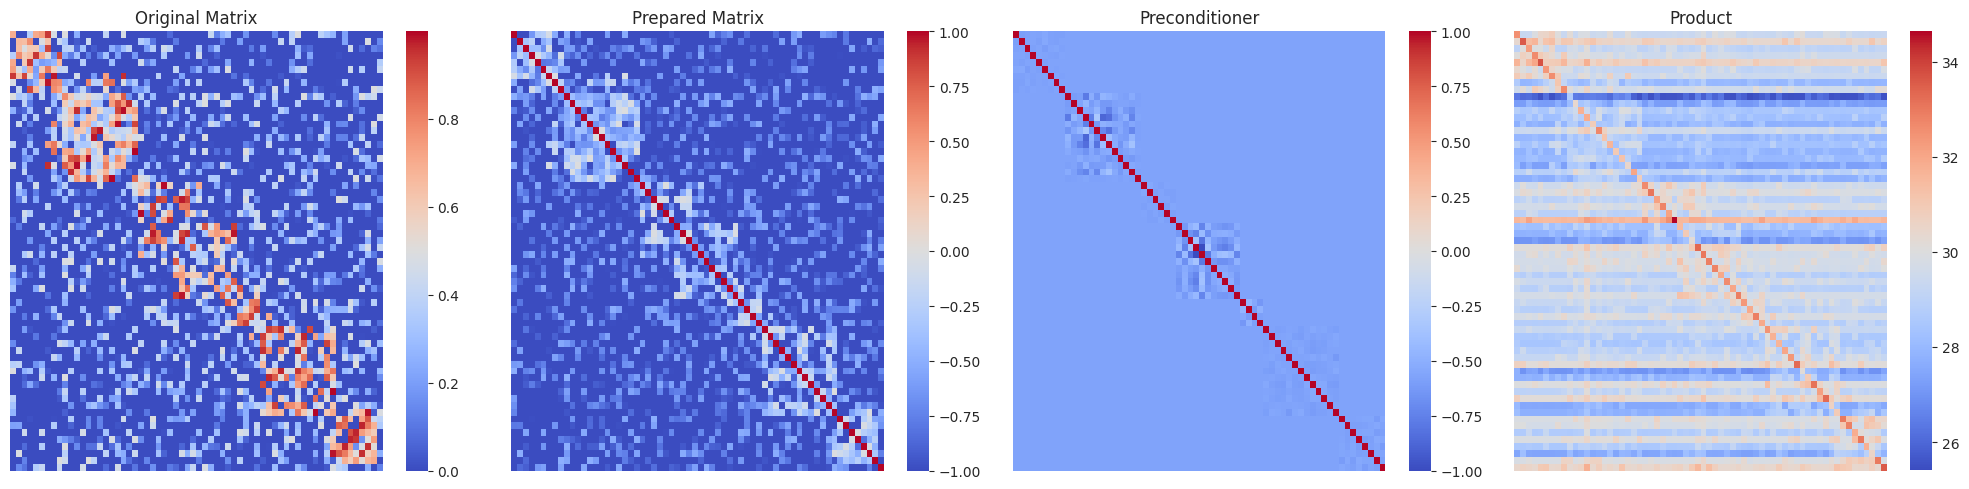

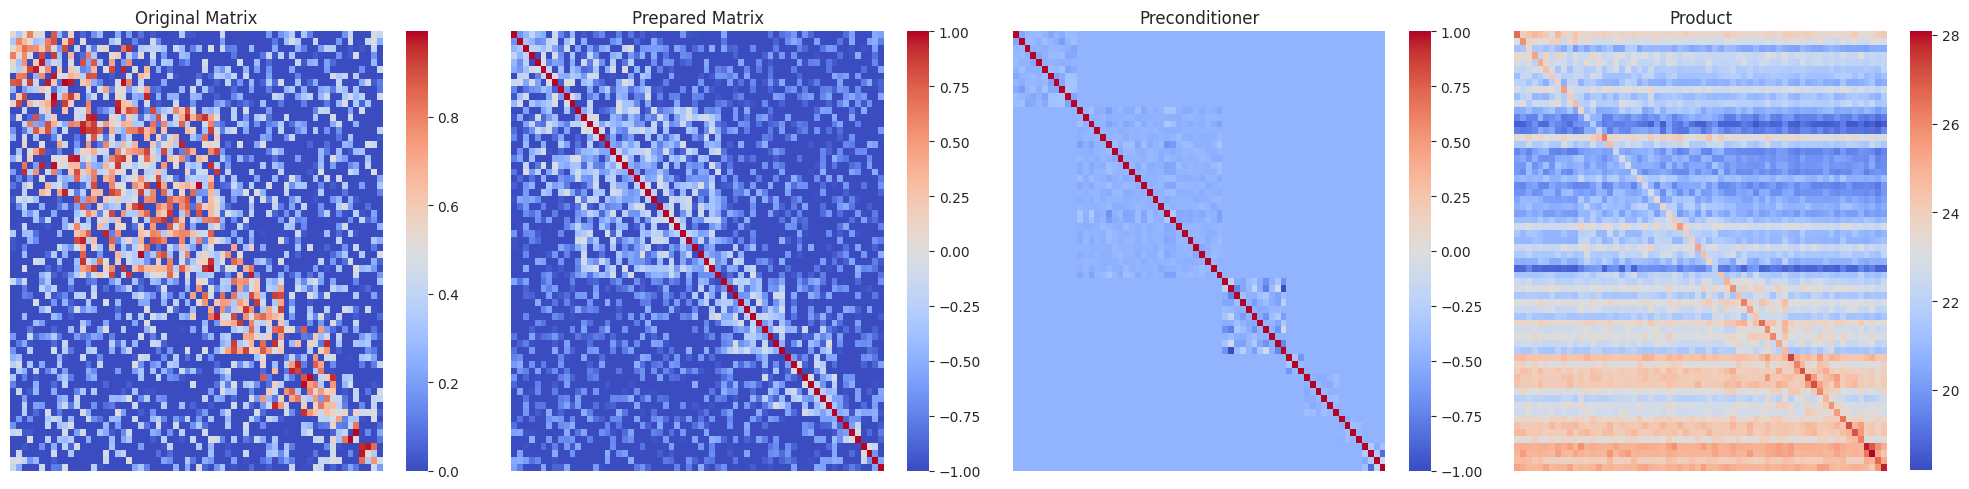

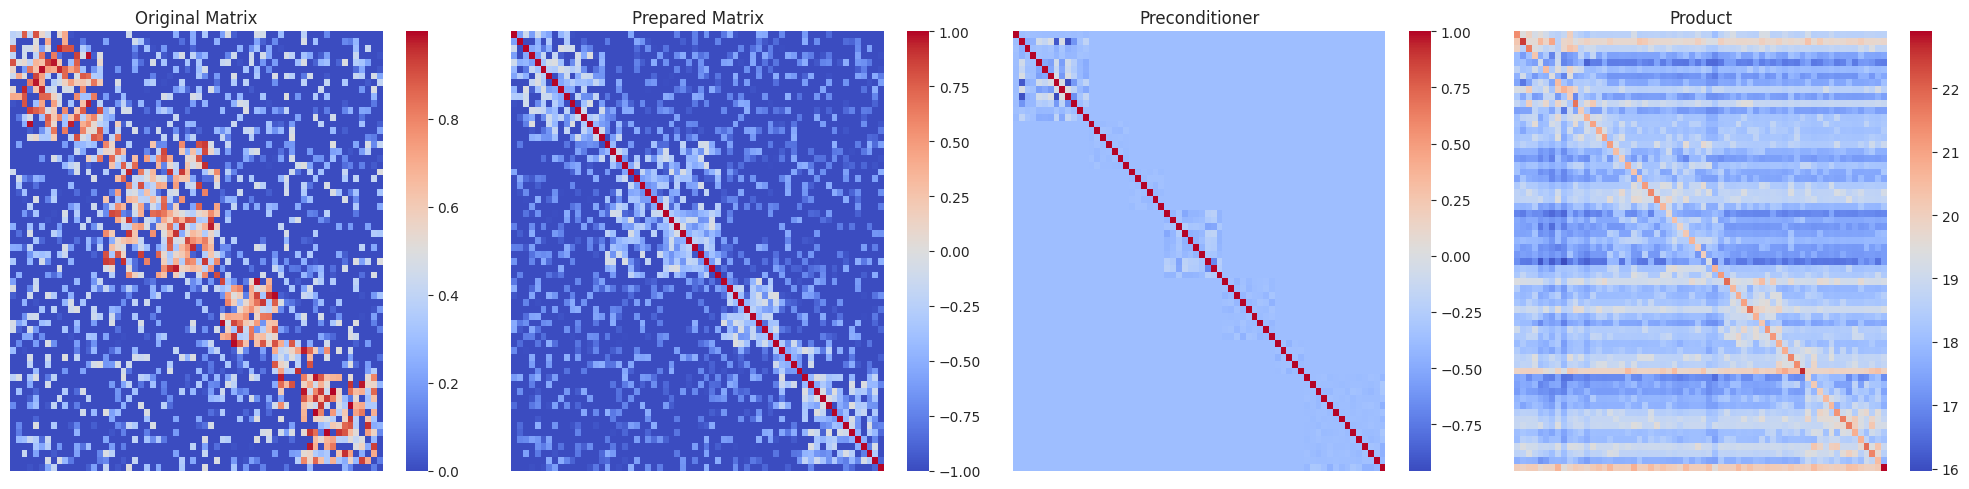

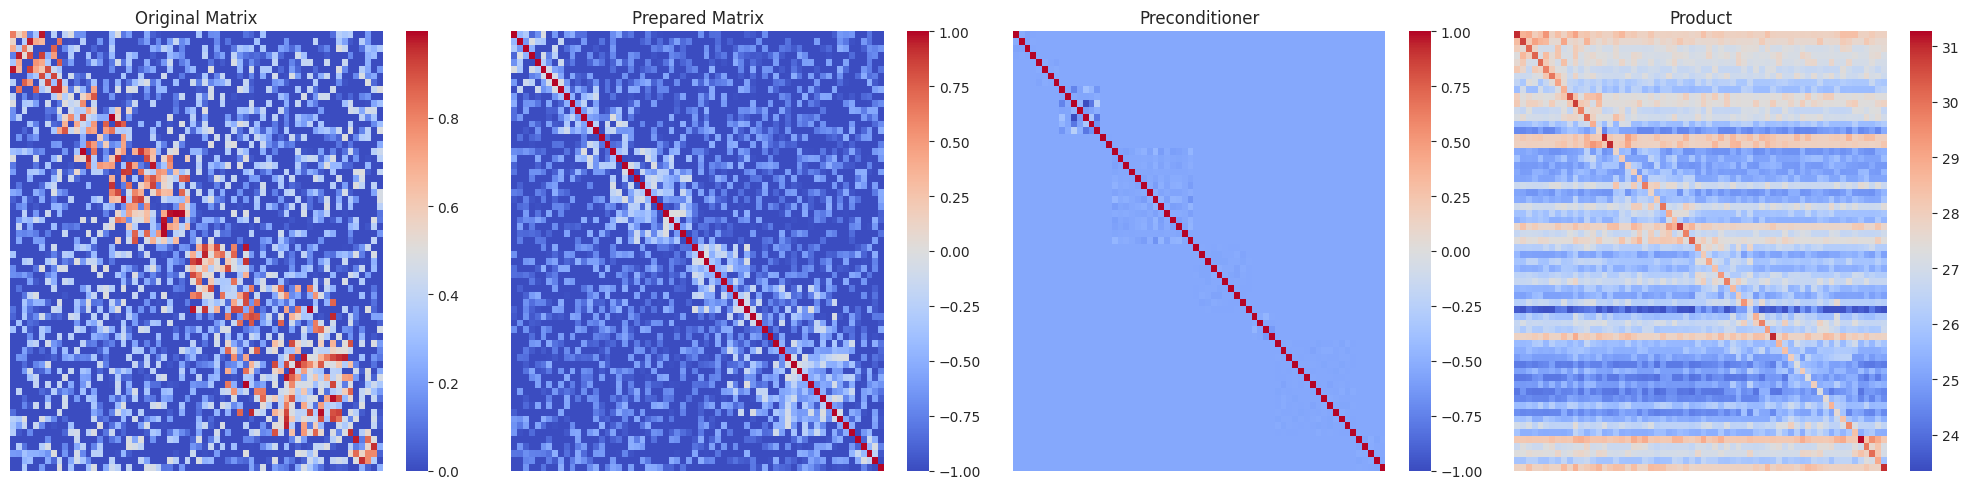

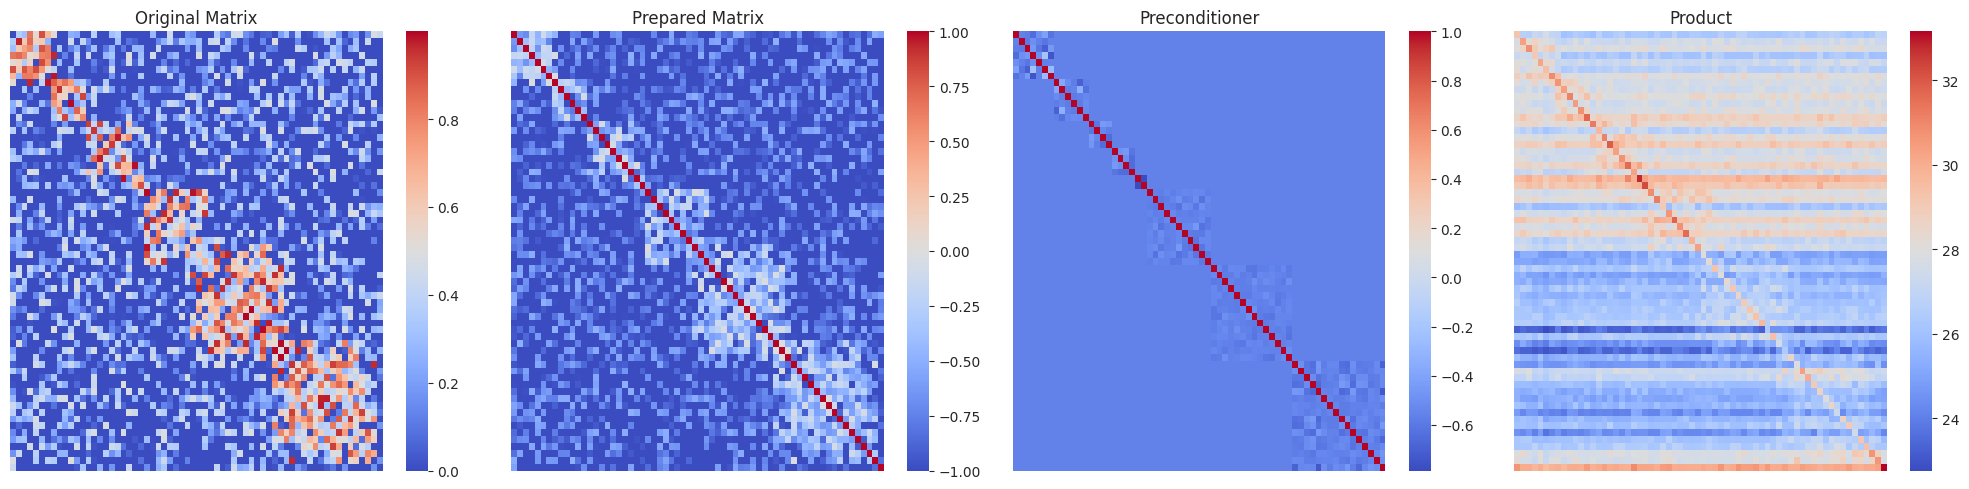

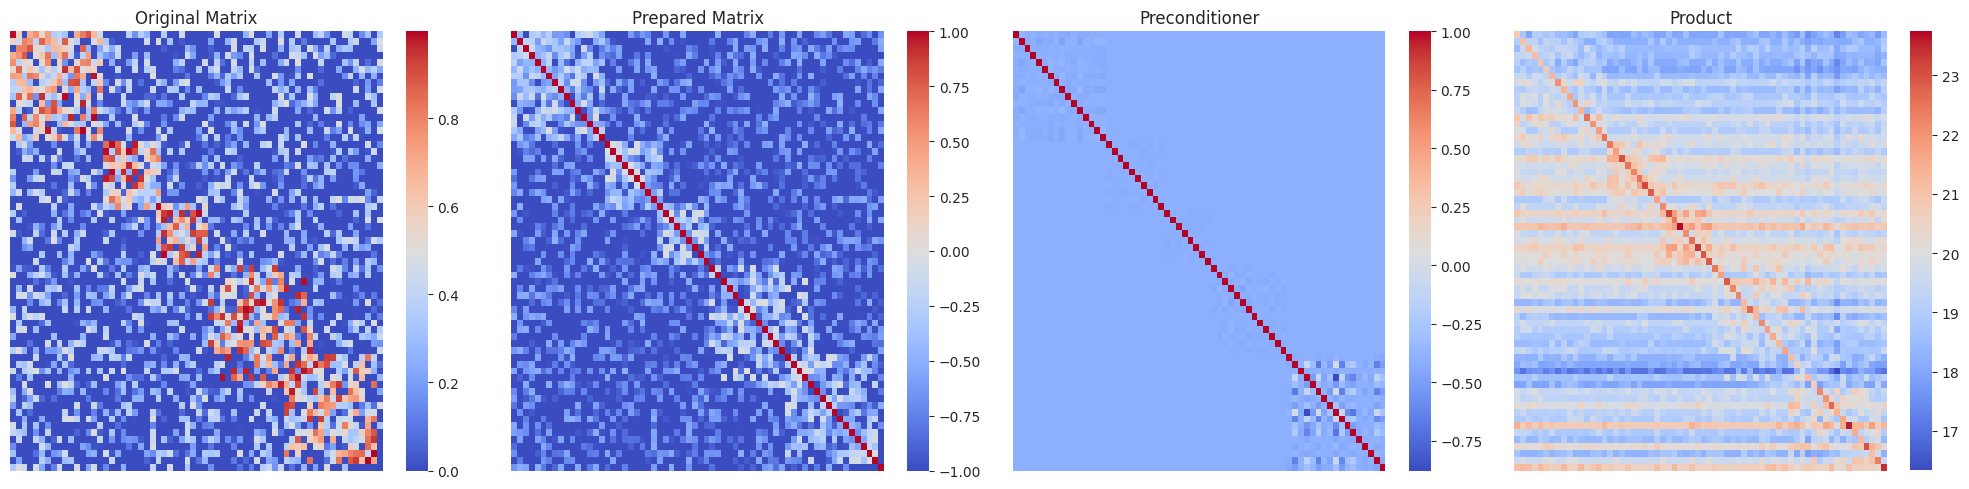

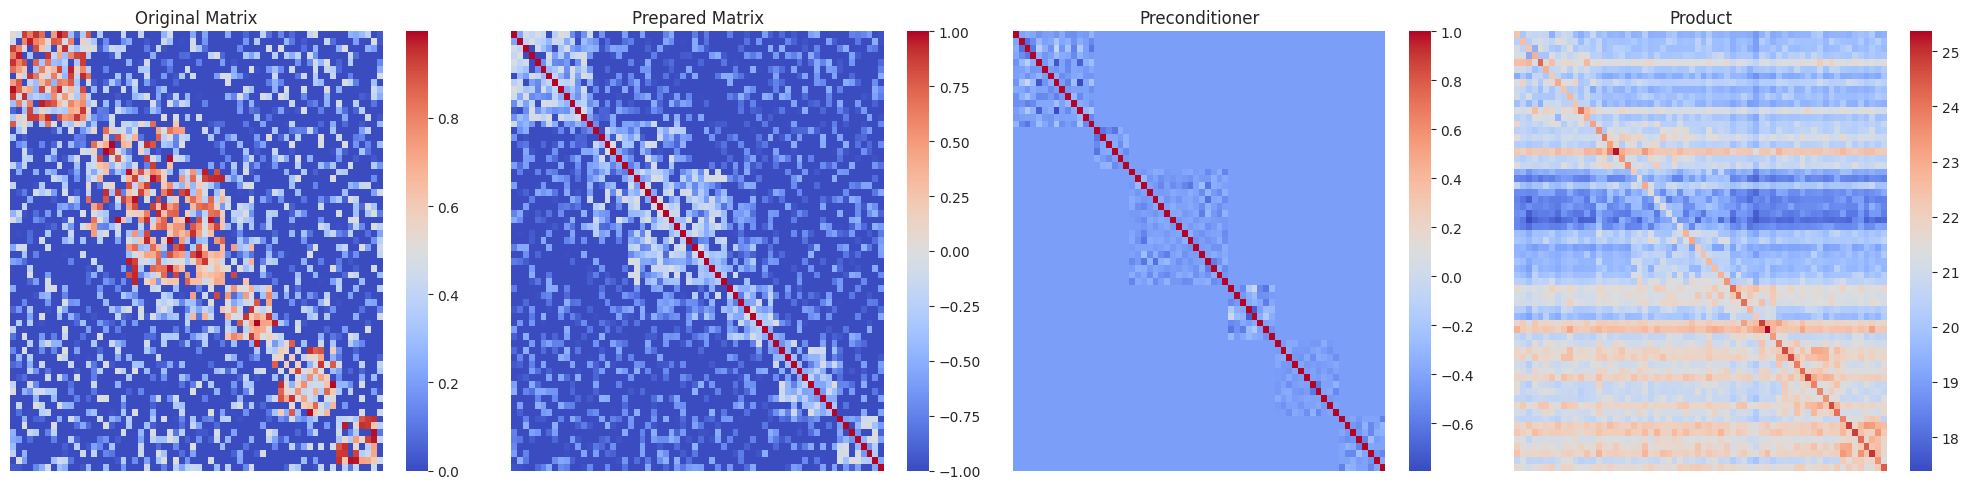

In [24]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
for i in range(10):
    plot_matrices(
        [test_matrices[i], A[i], precs[i], np.matmul(A[i], precs[i])], 
        ['Original Matrix', 'Prepared Matrix', 'Preconditioner', 'Product'], 
        colorbar='coolwarm'
    )